In [ ]:
# import necessary libraries
!pip install spacy_sentence_bert
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from html.parser import HTMLParser
import nltk
from nltk.stem.wordnet import WordNetLemmatizer
nltk.download("stopwords")
nltk.download("punkt")
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.corpus import stopwords
stop_words = set(stopwords.words("english"))
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
import re
import pickle
from wordcloud import WordCloud
import more_itertools
import spacy_sentence_bert
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, HashingVectorizer
from yellowbrick.text import TSNEVisualizer
from sklearn.decomposition import PCA
import seaborn as sns
from tqdm import tqdm
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, PrecisionRecallDisplay, f1_score ,cohen_kappa_score, matthews_corrcoef, log_loss, average_precision_score, precision_recall_curve

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


Data Collection & Storage

In [ ]:
#Loading the tweets data
df = pd.read_csv('tweets_label.csv', lineterminator="\n")
df.drop(['Unnamed: 0'], inplace=True, axis=1)
df.columns = ["text", "sentiment"]
df.head()

,text,sentiment
0,@AdamEShelton Good Morning \n\nTime to get som...,positive
1,BTCUSD for BITSTAMP:BTCUSD by MarwatTraders #B...,positive
2,@sassal0x What do you think happens to the pri...,positive
3,@rovercrc @MMCrypto @WhaleEverything @CryptoBu...,positive
4,BEAR ALERT ⚠️ - $ETH\n\n#ETH ENTERING BEARISH...,positive


In [ ]:
#Loading the reddit data
reddit_df = pd.read_csv("reddit_label.csv")
reddit_df.drop(['Unnamed: 0'], inplace=True, axis=1)
reddit_df.columns = ["text", "sentiment"]
reddit_df.head()

,text,sentiment
0,Brazil Are Looking To Ethereum To Improve Thei...,positive
1,BTC and LTC - Friends forever.,positive
2,Google you need to fix this :(,positive
3,‘India today is making the move to outlaw Bitc...,positive
4,"Salaries in Argentina to be paid in Bitcoin, b...",positive


In [ ]:
# joined the tweet and reddit data
df = pd.concat([df, reddit_df], axis=0, ignore_index=True)
df

,text,sentiment
0,@AdamEShelton Good Morning \n\nTime to get som...,positive
1,BTCUSD for BITSTAMP:BTCUSD by MarwatTraders #B...,positive
2,@sassal0x What do you think happens to the pri...,positive
3,@rovercrc @MMCrypto @WhaleEverything @CryptoBu...,positive
4,BEAR ALERT ⚠️ - $ETH\n\n#ETH ENTERING BEARISH...,positive
...,...,...
5947,just bought 5 LTC,positive
5948,At New Year's Eve party,positive
5949,VISA is looking for an engineer with Ethereum ...,positive
5950,Elon Musk tweeted about Cryptocurrency. Ask hi...,positive


Data Cleaning (Pre-processing Level 1)

In [ ]:
#Instantiate different text preprocessing class objects
StemmerInstance = PorterStemmer()
LemmatizerInstance = WordNetLemmatizer()
HTMLParserInstance = HTMLParser()

In [ ]:
#Load the required dictionary for text preprocessing (the dictionaries contains the mapping for different texts)
f = open("dict_apostrophe.pickle", "rb")
apostrophe_dict = pickle.load(f)
f = open("dict_short.pickle", "rb")
short_word_dict = pickle.load(f)
f = open("dict_emoji.pickle", "rb")
emoticon_dict = pickle.load(f)

In [ ]:
# preprocessing functions
def FunctionPattern(t, p):
    '''This function matches the required pattern inside the text using regex library and removes it'''
    r = re.findall(p, t)
    for i in r:
        t = re.sub(i, '', t)
    return t

def FunctionDict(t, d):
    '''This function splits the text into words and replace the word with the value mapped in the dictionary if present'''
    for w in t.split():
        if w.lower() in d:
            if w.lower() in t.split():
                t = t.replace(w, d[w.lower()])
    return t

In [ ]:
# get the cleaned text in a separate column
df['text_clean'] = df['text'].apply(lambda x: x.replace("\n", " "))
df['text_clean'] = df['text_clean'].apply(lambda x: HTMLParserInstance.unescape(x))
df['text_clean'] = np.vectorize(FunctionPattern)(df['text_clean'], "@[\w]*")
df['text_clean'] = df['text_clean'].apply(lambda x: x.lower())
df['text_clean'] = df['text_clean'].apply(lambda x: FunctionDict(x,apostrophe_dict))
df['text_clean'] = df['text_clean'].apply(lambda x: FunctionDict(x,short_word_dict))
df['text_clean'] = df['text_clean'].apply(lambda x: FunctionDict(x,emoticon_dict))
df['text_clean'] = df['text_clean'].apply(lambda x: re.sub(r'[^\w\s]',' ',x))
df['text_clean'] = df['text_clean'].apply(lambda x: re.sub(r'[^a-zA-Z0-9]',' ',x))
df['text_clean'] = df['text_clean'].apply(lambda x: re.sub(r'[^a-zA-Z]',' ',x))
df['text_clean'] = df['text_clean'].apply(lambda x: x.replace(" co ", " "))
df['text_clean'] = df['text_clean'].apply(lambda x: x.replace(" https ", " "))
df['text_clean'] = df['text_clean'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>1]))
df.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: The unescape method is deprecated and will be removed in 3.5, use html.unescape() instead.
  This is separate from the ipykernel package so we can avoid doing imports until


,text,sentiment,text_clean
0,@AdamEShelton Good Morning \n\nTime to get som...,positive,good morning time to get some nutra nutratoken...
1,BTCUSD for BITSTAMP:BTCUSD by MarwatTraders #B...,positive,btcusd for bitstamp btcusd by marwattraders bt...
2,@sassal0x What do you think happens to the pri...,positive,what do you think happens to the price of eth ...
3,@rovercrc @MMCrypto @WhaleEverything @CryptoBu...,positive,what has what is your advice for all the first...
4,BEAR ALERT ⚠️ - $ETH\n\n#ETH ENTERING BEARISH...,positive,bear alert eth eth entering bearish channel du...


In [ ]:
# nltk.download('omw-1.4')
# create and save tokens, stemmed and lemmatized text
df["word_tokens"] = df['text_clean'].apply(lambda x: word_tokenize(x))
#Create new column containing tweets converted to word tokens with stop words removed
df['word_tokens'] = df["word_tokens"].apply(lambda x: [w for w in x if not w in stop_words])
#Create new column containing stemmed clean tweets
df['stemmed'] = df['word_tokens'].apply(lambda x: ' '.join([StemmerInstance.stem(i) for i in x]))
#Create new column containing lemmatized clean tweets
df['lemmatized'] = df['word_tokens'].apply(lambda x: ' '.join([LemmatizerInstance.lemmatize(i) for i in x]))
df.head()

,text,sentiment,text_clean,word_tokens,stemmed,lemmatized
0,@AdamEShelton Good Morning \n\nTime to get som...,positive,good morning time to get some nutra nutratoken...,"[good, morning, time, get, nutra, nutratoken, ...",good morn time get nutra nutratoken ezea lswyn...,good morning time get nutra nutratoken ezea ls...
1,BTCUSD for BITSTAMP:BTCUSD by MarwatTraders #B...,positive,btcusd for bitstamp btcusd by marwattraders bt...,"[btcusd, bitstamp, btcusd, marwattraders, btc,...",btcusd bitstamp btcusd marwattrad btc crypto b...,btcusd bitstamp btcusd marwattraders btc crypt...
2,@sassal0x What do you think happens to the pri...,positive,what do you think happens to the price of eth ...,"[think, happens, price, eth, millions, ethereu...",think happen price eth million ethereum unlock...,think happens price eth million ethereum unloc...
3,@rovercrc @MMCrypto @WhaleEverything @CryptoBu...,positive,what has what is your advice for all the first...,"[advice, first, time, investors, getting, dest...",advic first time investor get destroy btc ethe...,advice first time investor getting destroyed b...
4,BEAR ALERT ⚠️ - $ETH\n\n#ETH ENTERING BEARISH...,positive,bear alert eth eth entering bearish channel du...,"[bear, alert, eth, eth, entering, bearish, cha...",bear alert eth eth enter bearish channel due b...,bear alert eth eth entering bearish channel du...


EDA

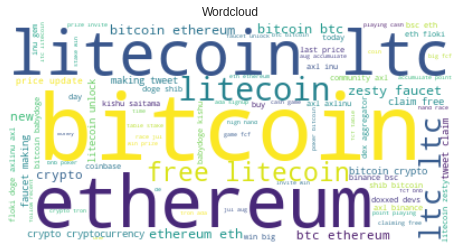

In [ ]:
def plot_wordcloud(column_name='lemmatized'):
  '''This function plots the wordcloud for the desired text column'''
  WordString = ' '.join([w for w in df[column_name]])
  wordcloud = WordCloud(background_color="white").generate(WordString)
  plt.imshow(wordcloud, interpolation="bilinear")
  plt.title("Wordcloud")
  plt.axis("off")
  plt.show()

plot_wordcloud()

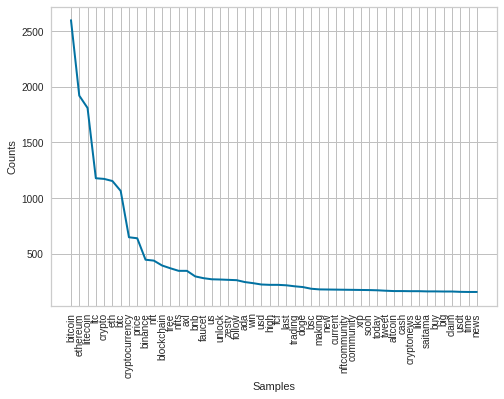

In [ ]:
# frequency distribution plot
token = df['word_tokens']
x = token.tolist()
tokens = list(more_itertools.collapse(x))
fdist = nltk.FreqDist(tokens)
fdist.plot(50)

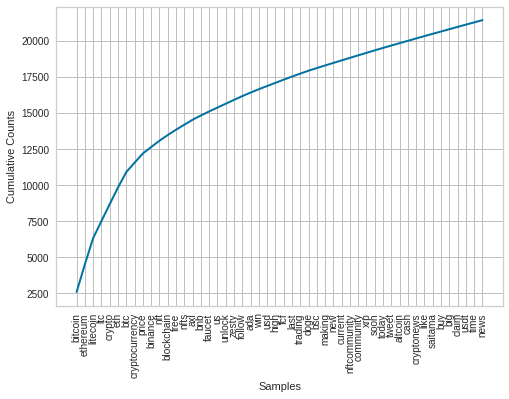

In [ ]:
# cumulative frequency distribution plot
fdist.plot(50, cumulative = True);

Feature Selection (Pre-processing Level 2)

In [ ]:
df["sentiment"].value_counts()

positive    4721
negative    1078
neutral      153
Name: sentiment, dtype: int64

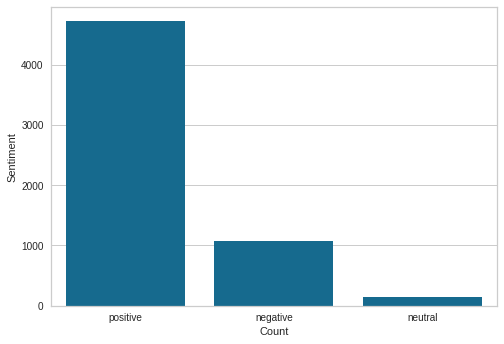

In [ ]:
ax = sns.barplot(y = df['sentiment'].value_counts(), x = df['sentiment'].value_counts().index, color='b')
plt.xlabel("Count")
plt.ylabel("Sentiment")
plt.show()

We see that we have a major imbalance in the dataset. We will be completely removing "neutral" class and then we will try to balance the dataset using SMOTE.

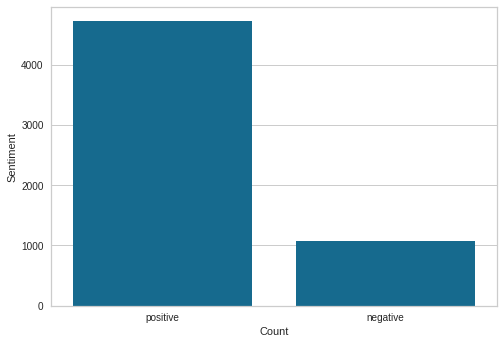

In [ ]:
df = df[df["sentiment"] != "neutral"] # dropped neutral class
ax = sns.barplot(y = df['sentiment'].value_counts(), x = df['sentiment'].value_counts().index, color='b')
plt.xlabel("Count")
plt.ylabel("Sentiment")
plt.show()

In [ ]:
label_encoder = LabelEncoder()
df["sentiment"] = label_encoder.fit_transform(df["sentiment"]) # we label encode our target label

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
# vector embedding function
def vector_embedding(embedding_name='tfidf', column_name='lemmatized'):
  '''This function instantiate the required embedding object and return the transformed vector embeddings'''
  if embedding_name=='count':
    vec = CountVectorizer()
    embd = vec.fit_transform(df[column_name])
    return embd, vec
  elif embedding_name=='tfidf':
    vec = TfidfVectorizer()
    embd = vec.fit_transform(df[column_name])
    return embd, vec
  elif embedding_name=='hash':
    vec = HashingVectorizer()
    embd = vec.fit_transform(df[column_name])
    return embd, vec
  elif embedding_name=='bert':
    vec = spacy_sentence_bert.load_model('en_nli_bert_base')
    embd = df[column_name].apply(lambda x: vec(x).vector).to_list()
    return embd, vec
  elif embedding_name=='distil':
    vec = spacy_sentence_bert.load_model('en_stsb_distilbert_base')
    embd = df[column_name].apply(lambda x: vec(x).vector).to_list()
    return embd, vec
  else:
    print('Invalid embedding!!')

In [ ]:
count_embedding, vectorizer = vector_embedding(embedding_name='count') # we create the count vectorizer matrix
cv = pd.DataFrame(data = count_embedding.toarray(), columns=vectorizer.get_feature_names())
print("{} rows".format(cv.shape[0]))
cv.T.nlargest(5, 0) # top 5 words

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


5799 rows


,0,1,2,3,4,5,6,7,8,9,...,5789,5790,5791,5792,5793,5794,5795,5796,5797,5798
nutra,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
cc,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
crypto,1,1,0,1,0,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
cryptocurrency,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
cryptogiveaway,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
tfidf_embedding, vectorizer = vector_embedding(embedding_name='tfidf') # we create the tfidf matrix
tf_idf = pd.DataFrame(data = tfidf_embedding.toarray(), columns=vectorizer.get_feature_names())
print("{} rows".format(tf_idf.shape[0]))
tf_idf.T.nlargest(5, 0) # first 5 words with the highest weights

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


5799 rows


,0,1,2,3,4,5,6,7,8,9,...,5789,5790,5791,5792,5793,5794,5795,5796,5797,5798
nutra,0.565506,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ejxpojw,0.282753,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ezea,0.282753,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
lswyn,0.282753,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
nutraceuticalfinance,0.282753,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Data Mining

Principal Component Analysis

In [ ]:
pca_data_dict = {}
for num_features in tqdm(range(0,500,20)):
    pca = PCA(n_components=num_features)
    reduced_data = pca.fit_transform(tf_idf)
    exp_var = sum(pca.explained_variance_ratio_)
    pca_data_dict[num_features] = exp_var

100%|██████████| 25/25 [13:45<00:00, 33.02s/it]


TypeError: ignored

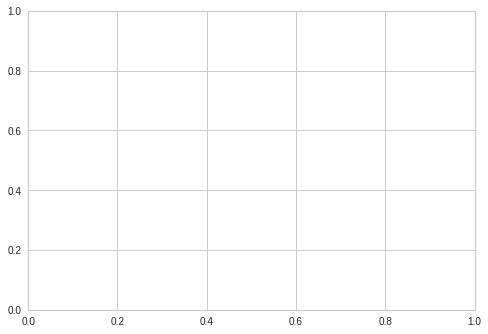

In [ ]:
plt.plot(pca_data_dict.keys(), pca_data_dict.values())
plt.xlabel("No. of reduced features")
plt.ylabel("Total Explained Variance")
plt.show()

In [ ]:
for i in pca_data_dict.keys():
    if pca_data_dict[i] > 0.5:
        total_exp_var = pca_data_dict[i]
        num_features = i
        print(f"{num_features} features explains {round(total_exp_var*100)} percent of the variance.")
        break

380 features explains 50 percent of the variance.


t-distributed stochastic neighbour embedding (t-SNE)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


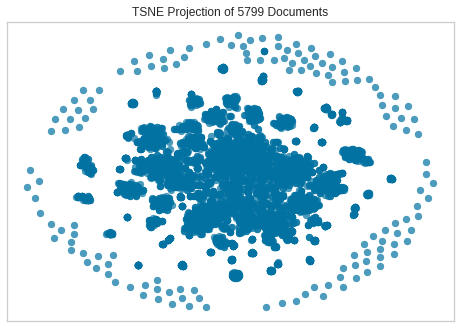

In [ ]:
tsneObject = TSNEVisualizer()
tsneObject.fit(tf_idf)
tsneObject.poof()

In [ ]:
# define training and predict function
def train_and_predict(classifier_name='RF'):
  '''This function instatiate the required classifier object and return it'''
  rf = RandomForestClassifier(random_state=45)
  dt = DecisionTreeClassifier(random_state=45)
  knn = KNeighborsClassifier()
  svc = SVC(probability=True, random_state=45)
  gbc = GradientBoostingClassifier(random_state=45)
  ensemble = VotingClassifier(estimators=[('RF', rf), ('DT', dt), ('KNN', knn), ('SVC', svc), ('GBC', gbc)], voting='soft')
  if classifier_name=='RF':
    return rf
  elif classifier_name=='DT':
    return dt
  elif classifier_name=='KNN':
    return knn
  elif classifier_name=='SVC':
    return svc
  elif classifier_name=="GBC":
    return gbc
  elif classifier_name=='ENSEMBLE':
    return ensemble
  else:
    print("Invalid Classifier Name!!")

In [ ]:
# a function to get all metrics
def get_metrics(y_test, y_pred, y_pred_probs):
    print(classification_report(y_test, y_pred))
    roc_auc = roc_auc_score(y_test, y_pred)
    pr_auc_score = average_precision_score(y_test, y_pred)
    cohen_kappa = cohen_kappa_score(y_test, y_pred)
    mat_cc = matthews_corrcoef(y_test, y_pred)
    log_l = log_loss(y_test, y_pred_probs)
    f1_s = f1_score(y_test, y_pred)
    print(f"ROC AUC Score: {roc_auc}")
    print(f"PR AUC Score: {pr_auc_score}")
    print(f"F1 Score: {f1_s}")
    print(f"Cohen Kappa Score: {cohen_kappa}")
    print(f"Matthews Correlation Coefficient: {mat_cc}")
    print(f"Log Loss: {log_l}")
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="Blues")
    plt.title("CONFUSION MATRIX")
    plt.show()
    p, r, _ = precision_recall_curve(y_test, y_pred)
    display = PrecisionRecallDisplay(r, p)
    display.plot()
    scores_list = [roc_auc, pr_auc_score, f1_s, cohen_kappa, mat_cc, log_l]
    return scores_list

In [ ]:
# a pipeline function to test the best vectorizers
def get_best_vectorizer(classifier_name='ENSEMBLE'):
    vectorizers_list = ['count', 'tfidf', 'hash', 'bert', 'distil']
    vec_metrics_df = pd.DataFrame(columns=["Name", "ROC AUC", "PR AUC", "F1", "Cohen Kappa", "MatthewsCC", "LogLoss"])
    counter = 0
    for vectorizer_name in vectorizers_list:
        #vector embedding
        embd, _ = vector_embedding(embedding_name=vectorizer_name)
        # train test split of embedding
        X_train, X_test, y_train, y_test = train_test_split(embd, df["sentiment"], test_size=0.2, stratify=df["sentiment"], random_state=45)
        # SMOTE to balance classes in training set
        SMOTE_Initializer = SMOTE(random_state=45)
        X_res, y_res = SMOTE_Initializer.fit_resample(X_train, y_train)
        # fit the model with balanced data
        clasifierInstance = train_and_predict(classifier_name=classifier_name)
        clasifierInstance.fit(X_res, y_res)
        # get prediction of testing data
        y_pred = clasifierInstance.predict(X_test)
        y_pred_probs = clasifierInstance.predict_proba(X_test)
        # visualize metrics for each vectorizer
        print(vectorizer_name)
        metrics = get_metrics(y_test, y_pred, y_pred_probs)
        # get all vectorizers performance in a table
        metrics.insert(0, vectorizer_name)
        vec_metrics_df.loc[counter] = metrics
        counter += 1
    print(vec_metrics_df) # visualize table

count
              precision    recall  f1-score   support

           0       0.36      0.71      0.48       216
           1       0.91      0.71      0.80       944

    accuracy                           0.71      1160
   macro avg       0.64      0.71      0.64      1160
weighted avg       0.81      0.71      0.74      1160

ROC AUC Score: 0.7090395480225988
PR AUC Score: 0.8849513181300995
F1 Score: 0.7990459153249851
Cohen Kappa Score: 0.3036892429143452
Matthews Correlation Coefficient: 0.33744686772948496
Log Loss: 0.5633486720613956


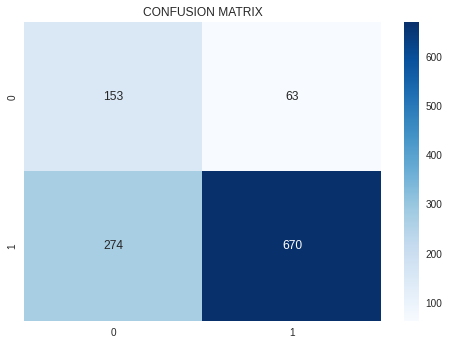

tfidf
              precision    recall  f1-score   support

           0       0.48      0.55      0.51       216
           1       0.89      0.86      0.88       944

    accuracy                           0.80      1160
   macro avg       0.68      0.71      0.69      1160
weighted avg       0.82      0.80      0.81      1160

ROC AUC Score: 0.706077369742624
PR AUC Score: 0.8823585349483948
F1 Score: 0.8770226537216829
Cohen Kappa Score: 0.3885703717403366
Matthews Correlation Coefficient: 0.3901956922745655
Log Loss: 0.45325860605119855


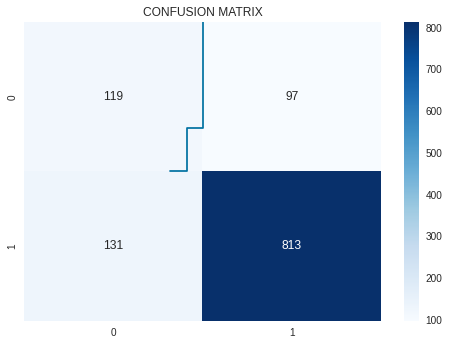

hash
              precision    recall  f1-score   support

           0       0.48      0.53      0.50       216
           1       0.89      0.87      0.88       944

    accuracy                           0.80      1160
   macro avg       0.68      0.70      0.69      1160
weighted avg       0.81      0.80      0.81      1160

ROC AUC Score: 0.6989367545511613
PR AUC Score: 0.8797287336585391
F1 Score: 0.8775510204081632
Cohen Kappa Score: 0.38022571332158517
Matthews Correlation Coefficient: 0.38117891838958157
Log Loss: 0.4466047954046269


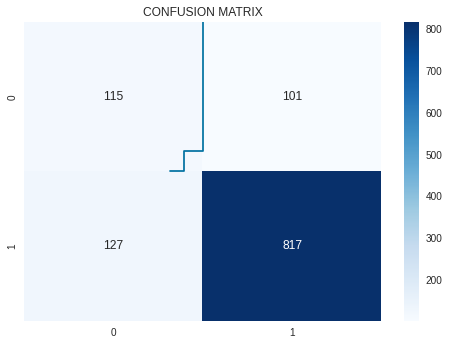

Downloading:   0%|          | 0.00/690 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.89k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/613 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/122 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/438M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/375 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/229 [00:00<?, ?B/s]

bert
              precision    recall  f1-score   support

           0       0.49      0.62      0.54       216
           1       0.91      0.85      0.88       944

    accuracy                           0.81      1160
   macro avg       0.70      0.73      0.71      1160
weighted avg       0.83      0.81      0.82      1160

ROC AUC Score: 0.7331881669805399
PR AUC Score: 0.8925002358263421
F1 Score: 0.8775956284153006
Cohen Kappa Score: 0.42261883599388483
Matthews Correlation Coefficient: 0.42742235674444684
Log Loss: 0.422094924641244


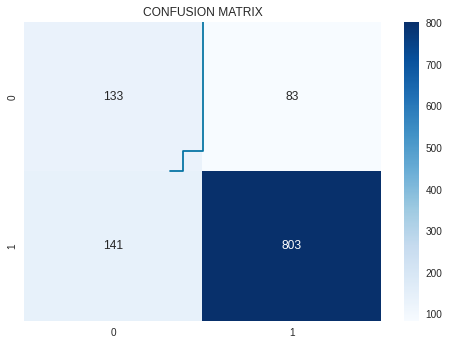

Downloading:   0%|          | 0.00/523 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.93k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/539 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/122 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/265M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/489 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/229 [00:00<?, ?B/s]

distil
              precision    recall  f1-score   support

           0       0.50      0.63      0.56       216
           1       0.91      0.86      0.88       944

    accuracy                           0.81      1160
   macro avg       0.71      0.74      0.72      1160
weighted avg       0.83      0.81      0.82      1160

ROC AUC Score: 0.7433105775266792
PR AUC Score: 0.8962512384300881
F1 Score: 0.8827059465357338
Cohen Kappa Score: 0.4431146281774173
Matthews Correlation Coefficient: 0.44768065893555126
Log Loss: 0.40931672337979375


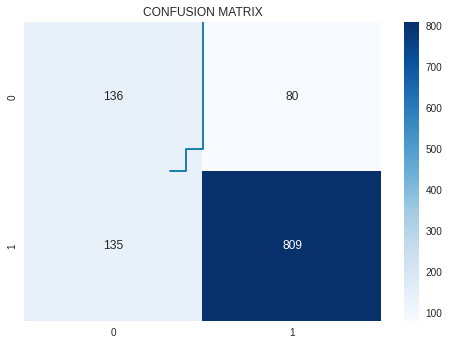

     Name   ROC AUC    PR AUC        F1  Cohen Kappa  MatthewsCC   LogLoss
0   count  0.709040  0.884951  0.799046     0.303689    0.337447  0.563349
1   tfidf  0.706077  0.882359  0.877023     0.388570    0.390196  0.453259
2    hash  0.698937  0.879729  0.877551     0.380226    0.381179  0.446605
3    bert  0.733188  0.892500  0.877596     0.422619    0.427422  0.422095
4  distil  0.743311  0.896251  0.882706     0.443115    0.447681  0.409317


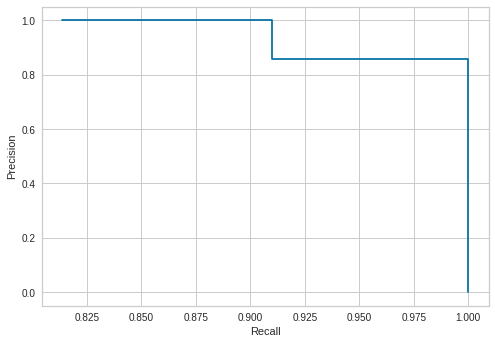

In [ ]:
# we find the performance of all vectorizers for comparison
get_best_vectorizer(classifier_name="ENSEMBLE")

We see that performance is on par among various vectorizers. We will use tf-idf vectorizer to determine the best model for our use case because ........

In [ ]:
tfidf_embeddings, tfidf_vectorizer = vector_embedding(embedding_name="tfidf") # get the bert vector embeddings

In [ ]:
X = tfidf_embeddings
y = df["sentiment"]
# we split our dataset into training and testing splits
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=45)
# we fit SMOTE to balance our training set
SMOTE_Initializer = SMOTE(random_state=45)
X_res, y_res = SMOTE_Initializer.fit_resample(X_train, y_train)

In [ ]:
def get_best_model(models_list):
    model_metrics_df = pd.DataFrame(columns=["Name", "ROC AUC", "PR AUC", "F1", "Cohen Kappa", "MatthewsCC", "LogLoss"])
    counter = 0
    for model_name in models_list:
    # fit the model with balanced data
        clasifierInstance = train_and_predict(classifier_name=model_name)
        clasifierInstance.fit(X_res, y_res)
        # get prediction of testing data
        y_pred = clasifierInstance.predict(X_test)
        y_pred_probs = clasifierInstance.predict_proba(X_test)
        # visualize metrics for each vectorizer
        print(model_name)
        metrics = get_metrics(y_test, y_pred, y_pred_probs)
        # get all models performance in a table
        metrics.insert(0, model_name)
        model_metrics_df.loc[counter] = metrics
        counter += 1
    print(model_metrics_df) # visualize table


RF
              precision    recall  f1-score   support

           0       0.46      0.49      0.47       216
           1       0.88      0.87      0.87       944

    accuracy                           0.80      1160
   macro avg       0.67      0.68      0.67      1160
weighted avg       0.80      0.80      0.80      1160

ROC AUC Score: 0.6773775894538607
PR AUC Score: 0.8719751076781876
F1 Score: 0.8746666666666666
Cohen Kappa Score: 0.346709101018041
Matthews Correlation Coefficient: 0.34693573504171643
Log Loss: 0.46730329961456857


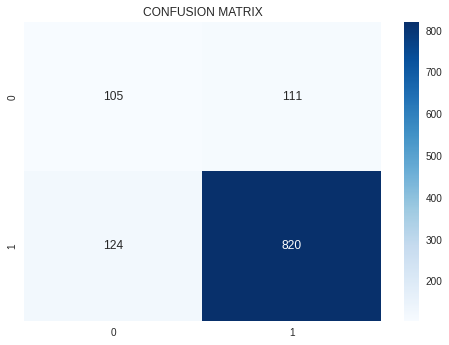

DT
              precision    recall  f1-score   support

           0       0.44      0.59      0.50       216
           1       0.90      0.83      0.86       944

    accuracy                           0.78      1160
   macro avg       0.67      0.71      0.68      1160
weighted avg       0.81      0.78      0.79      1160

ROC AUC Score: 0.7076467357187697
PR AUC Score: 0.8832127897915449
F1 Score: 0.8610804851157663
Cohen Kappa Score: 0.3668341708542714
Matthews Correlation Coefficient: 0.3733441505920978
Log Loss: 5.9861449415618795


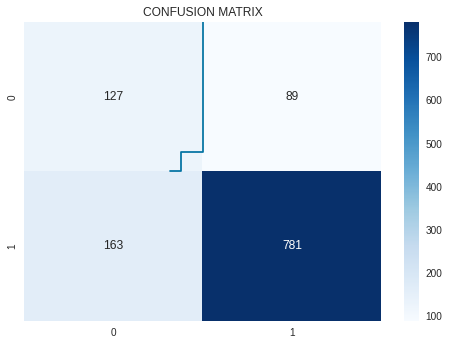

KNN
              precision    recall  f1-score   support

           0       0.23      0.94      0.37       216
           1       0.96      0.30      0.45       944

    accuracy                           0.42      1160
   macro avg       0.59      0.62      0.41      1160
weighted avg       0.82      0.42      0.44      1160

ROC AUC Score: 0.6176828311362209
PR AUC Score: 0.8556686238521092
F1 Score: 0.4514563106796116
Cohen Kappa Score: 0.10876817637886638
Matthews Correlation Coefficient: 0.21110799832555435
Log Loss: 15.184138335742418


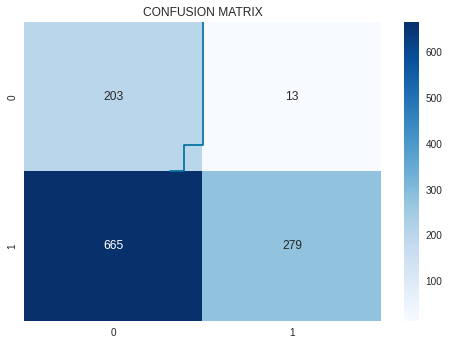

SVC
              precision    recall  f1-score   support

           0       0.73      0.33      0.46       216
           1       0.86      0.97      0.92       944

    accuracy                           0.85      1160
   macro avg       0.80      0.65      0.69      1160
weighted avg       0.84      0.85      0.83      1160

ROC AUC Score: 0.6528954802259888
PR AUC Score: 0.8630127589178694
F1 Score: 0.9152542372881357
Cohen Kappa Score: 0.38739499975147873
Matthews Correlation Coefficient: 0.4280181834645344
Log Loss: 0.4391332196394771


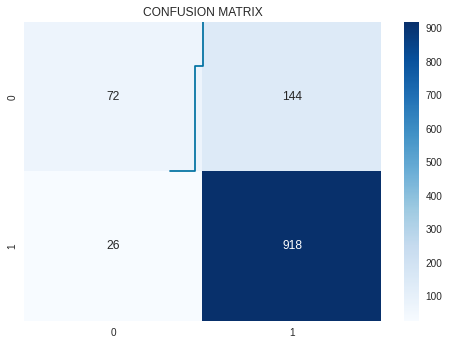

GBC
              precision    recall  f1-score   support

           0       0.36      0.74      0.49       216
           1       0.92      0.70      0.80       944

    accuracy                           0.71      1160
   macro avg       0.64      0.72      0.64      1160
weighted avg       0.82      0.71      0.74      1160

ROC AUC Score: 0.7220652856246076
PR AUC Score: 0.8900610429248652
F1 Score: 0.798076923076923
Cohen Kappa Score: 0.3172645739910315
Matthews Correlation Coefficient: 0.3563124149308674
Log Loss: 0.5027771403829855


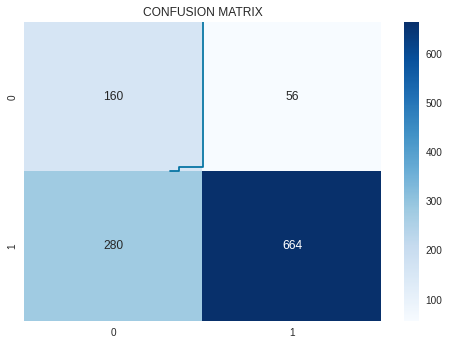

ENSEMBLE
              precision    recall  f1-score   support

           0       0.47      0.55      0.51       216
           1       0.89      0.86      0.88       944

    accuracy                           0.80      1160
   macro avg       0.68      0.71      0.69      1160
weighted avg       0.81      0.80      0.81      1160

ROC AUC Score: 0.7050180477087258
PR AUC Score: 0.8819881541953207
F1 Score: 0.8758099352051836
Cohen Kappa Score: 0.38527611885276114
Matthews Correlation Coefficient: 0.38707200969552735
Log Loss: 0.4544704211794281


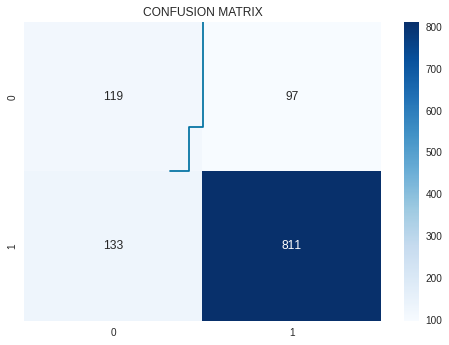

       Name   ROC AUC    PR AUC        F1  Cohen Kappa  MatthewsCC    LogLoss
0        RF  0.677378  0.871975  0.874667     0.346709    0.346936   0.467303
1        DT  0.707647  0.883213  0.861080     0.366834    0.373344   5.986145
2       KNN  0.617683  0.855669  0.451456     0.108768    0.211108  15.184138
3       SVC  0.652895  0.863013  0.915254     0.387395    0.428018   0.439133
4       GBC  0.722065  0.890061  0.798077     0.317265    0.356312   0.502777
5  ENSEMBLE  0.705018  0.881988  0.875810     0.385276    0.387072   0.454470


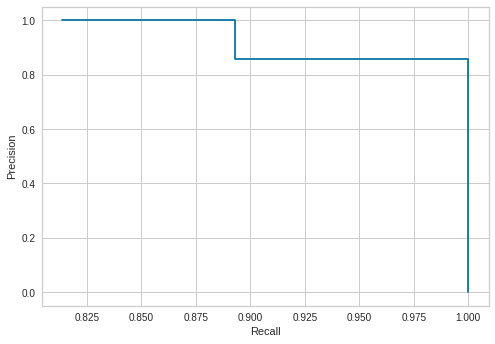

In [ ]:
models_list = ['RF', 'DT', 'KNN', 'SVC', 'GBC', 'ENSEMBLE']
get_best_model(models_list)

We see that SVC performed the best on our data in terms of F1 Score.
Next, we will try to further optimize the hyperparameters to increase its performance using Grid Search CV.

In [ ]:
param_grid = {'C': [1, 5, 10, 15, 20, 23, 25, 28, 35, 50], 
          'gamma': ['scale', 0.001, 0.01]}
model = SVC(random_state=45, kernel='rbf') # we use the gaussian radial basis function kernel (reasons: ......)
grid_clf = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=-1, verbose=10) # 5 folds CV on a stratified K-fold
grid_clf.fit(X_res, y_res)
print(grid_clf.best_estimator_)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
SVC(C=28, random_state=45)


In [ ]:
# fit the best SVC model with probability estimates turned on
svc_clf = SVC(C=25, random_state=45, probability=True)
svc_clf.fit(X_res, y_res)
y_pred = svc_clf.predict(X_test)
y_pred_probs = svc_clf.predict_proba(X_test)

              precision    recall  f1-score   support

           0       0.69      0.37      0.48       216
           1       0.87      0.96      0.91       944

    accuracy                           0.85      1160
   macro avg       0.78      0.66      0.70      1160
weighted avg       0.84      0.85      0.83      1160

ROC AUC Score: 0.6638025737602009
PR AUC Score: 0.8667980055872639
F1 Score: 0.9130216189039719
Cohen Kappa Score: 0.39966495153763304
Matthews Correlation Coefficient: 0.4267332903063116
Log Loss: 0.48046395925558366


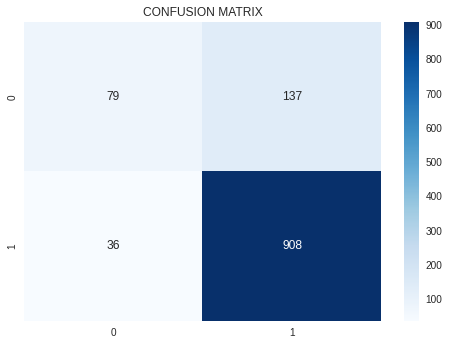

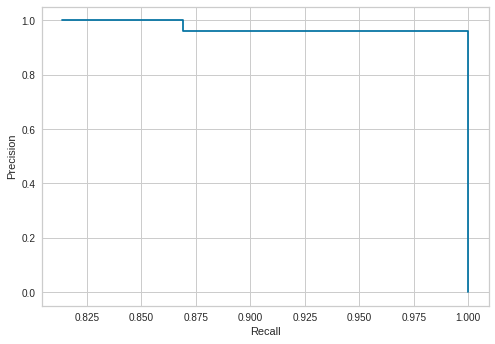

In [ ]:
# summarize the results of the grid search
results = get_metrics(y_test, y_pred, y_pred_probs)

In [ ]:
# we also fit the SVC model without any SMOTE application for the performance comparison
svc_clf_no_smote = SVC(C=25, random_state=45, probability=True)
svc_clf_no_smote.fit(X_train, y_train)
y_pred = svc_clf_no_smote.predict(X_test)
y_pred_probs = svc_clf_no_smote.predict_proba(X_test)

              precision    recall  f1-score   support

           0       0.74      0.37      0.49       216
           1       0.87      0.97      0.92       944

    accuracy                           0.86      1160
   macro avg       0.80      0.67      0.70      1160
weighted avg       0.85      0.86      0.84      1160

ROC AUC Score: 0.6680398618957941
PR AUC Score: 0.8682314813427223
F1 Score: 0.9173760640961443
Cohen Kappa Score: 0.41727354653286886
Matthews Correlation Coefficient: 0.4521152018124345
Log Loss: 0.370497125048453


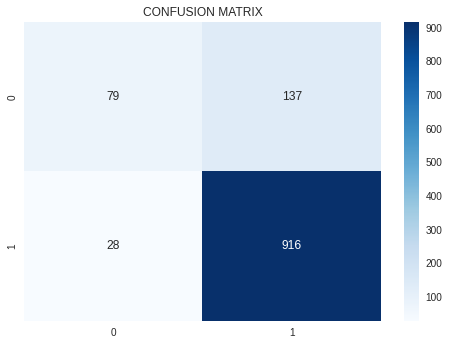

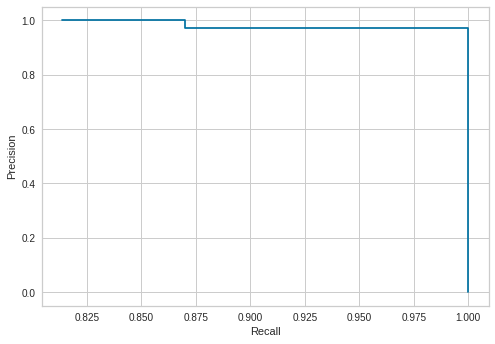

In [ ]:
# summarize the results of the no SMOTE experiment
results = get_metrics(y_test, y_pred, y_pred_probs)

In [ ]:
# we save the model and tfidf vectorizer for using in our dashboard

with open("model.pickle", "wb") as model_file_path:
    pickle.dump(svc_clf, model_file_path)

with open("tfidf_vectorizer.pickle", "wb") as tfidf_vec_file_path:
    pickle.dump(tfidf_vectorizer, tfidf_vec_file_path)